In [3]:
# Get the dataset
!wget -cq https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip

# Unzip
!unzip -qq ChestXRay2017.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [0]:
!ls

chest_xray  ChestXRay2017.zip  __MACOSX  sample_data


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras import layers
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [8]:
data_dir = 'ChestXRay2017/chest_xray'


train_dir = data_dir + '/train' # Path to train directory 
test_dir = data_dir + '/test' # Path to test directory

NORMAL


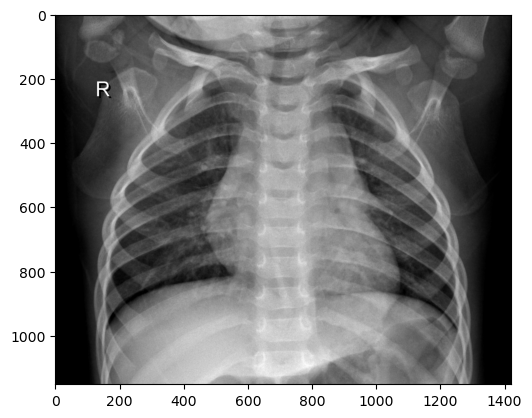

In [4]:
# Display Normal chest x-ray image
img_normal = load_img('ChestXRay2017/chest_xray/train/NORMAL/IM-0117-0001.jpeg')
print('NORMAL')
plt.imshow(img_normal)
plt.show()

PNEUMONIA


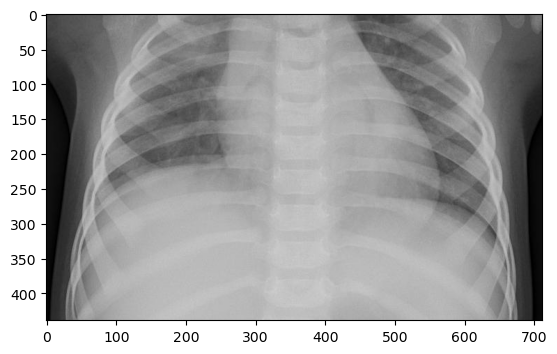

In [5]:
# Display Pneumonia chest x-ray image
img_pneumonia = load_img('ChestXRay2017/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg')
print('PNEUMONIA')
plt.imshow(img_pneumonia)
plt.show()

In [6]:
# Import VGG19 pre-trained model
vgg_model = VGG19(include_top=True, weights='imagenet')

In [7]:
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
# Pop off the last layer
vgg_model.layers.pop()

In [9]:
# Compile the model
predictions = Dense(1, activation='sigmoid')(vgg_model.layers[-1].output)
model = Model(inputs=vgg_model.input, outputs=predictions)

model.compile(optimizer = Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
# Prepare data augmentation configuration
train_datagen = ImageDataGenerator(rotation_range=40,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    batch_size=16,
                                                    class_mode='binary',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    batch_size=16,
                                                    class_mode='binary',
                                                    subset='validation')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224,224),
                                                  batch_size=16,
                                                  class_mode='binary')

Found 288 images belonging to 2 classes.
Found 32 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
# Number of train and validation steps
train_steps=train_generator.n//train_generator.batch_size
validation_steps=validation_generator.n//validation_generator.batch_size

In [14]:
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', save_best_only=True, verbose=1, mode='max')

In [15]:
# Train the model
history = model.fit_generator(train_generator,
                    steps_per_epoch=train_steps,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    epochs=1,
                    callbacks=[checkpoint])

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6656\1057593213.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


18/18 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.4861  WARNING:tensorflow:Can save best model only with val_acc available, skipping.


18/18 [==============================] - 3478s 193s/step - loss: 0.6940 - accuracy: 0.4861 - val_loss: 0.6933 - val_accuracy: 0.5000


In [19]:
model.save('my_model.h5')

C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
import tensorflow as tf
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
# new_model.summary()

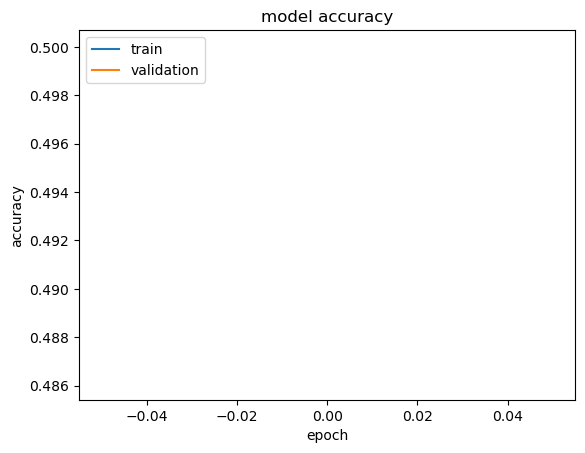

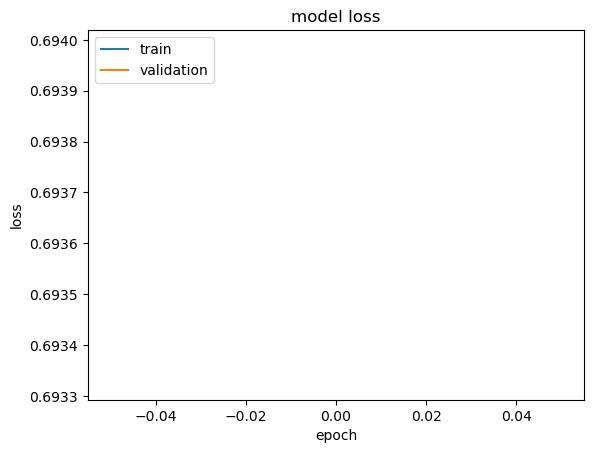

In [16]:
# Plot accuracy and loss graphs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [17]:
# Test the data
score = model.evaluate_generator(test_generator)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6656\1395018467.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_generator)


In [18]:
score

[0.6980507969856262, 0.375]

NORMAL


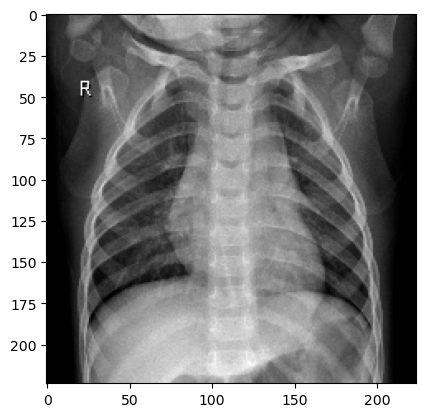

1/1 [==============================] - 1s 1s/step
Pneumonia


In [12]:
# Display Normal chest x-ray image
img_normal = load_img('ChestXRay2017/chest_xray/train/NORMAL/IM-0117-0001.jpeg',target_size=(224,224))
print('NORMAL')
plt.imshow(img_normal)
plt.show()
from keras.preprocessing import image 
img_normal=image.img_to_array(img_normal)
img_normal=np.expand_dims(img_normal,axis=0)
import cv2
# img_input=cv2.imread("ChestXRay2017/chest_xray/train/NORMAL/IM-0117-0001.jpeg")
result=new_model.predict(img_normal)
train_generator.class_indices
if result[0][0]==0:
    final_result="Normal"
    print("Normal")
else:
    final_result="Pneumonia"
    print("Pneumonia")